<a href="https://colab.research.google.com/github/InvestitoreComune/analysis/blob/main/three_fund_portfolio_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✓ Pacchetti installati con successo!
✓ Librerie importate
✓ Data esecuzione: 2025-11-25 13:46:59
✓ Configurazione caricata

Periodo analisi: 2005-01-01 → 2025-11-25
Capitale iniziale: €10,000
TER medio: 0.15%
Rolling window: 10 anni

Numero portafogli: 4
✓ Funzioni di calcolo caricate

🚀 ESECUZIONE BACKTEST

📊 DOWNLOAD DATI STORICI

Asset da scaricare: USA, WORLD, EXUSA, BOND

📈 BOND:
  Tentativo UCITS: IEAG.L... ✓ (4224 giorni)
📈 EXUSA:
  Tentativo UCITS: VEUR.L... ✓ (3163 giorni)
📈 USA:
  Tentativo UCITS: VUSA.L... ✓ (3413 giorni)
📈 WORLD:
  Tentativo UCITS: SWDA.L... ✓ (4084 giorni)

✓ Download completato!
✓ Periodo effettivo: 2013-05-21 → 2025-11-24
✓ Giorni di trading: 3,163
✓ Asset disponibili: 4

----------------------------------------------------------------------
📊 COSTRUZIONE PORTAFOGLI
----------------------------------------------------------------------

Costruendo: Three-Fund (40/30/30)
  Allocazione: {'USA': 0.4, 'EXUSA': 0.3, 'BOND': 0.3}
  ✓ Completato

Costruendo: 60

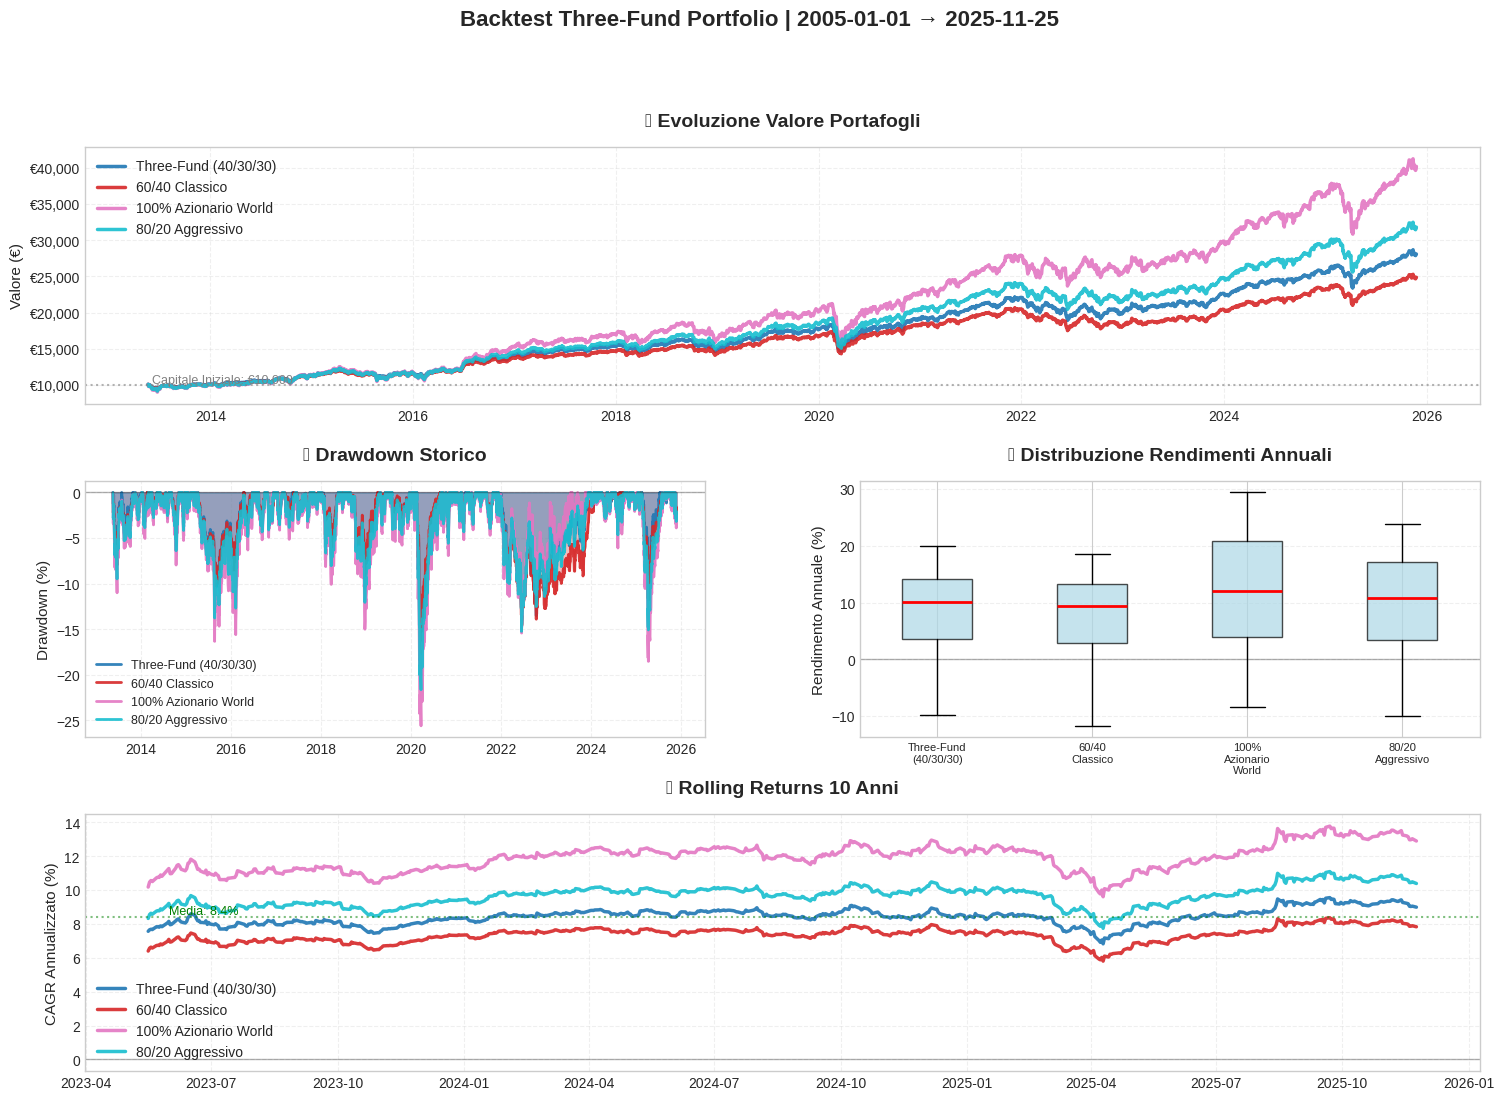


📊 ANALISI ROLLING RETURNS 10 ANNI

                       Min CAGR (%)  Max CAGR (%)  Media CAGR (%)  Mediana CAGR (%)  Dev. Std. (%)  % Periodi >0%  % Periodi >5%
Three-Fund (40/30/30)          6.83          9.55            8.42              8.46           0.47          100.0          100.0
60/40 Classico                 5.81          8.37            7.35              7.42           0.45          100.0          100.0
100% Azionario World           9.61         13.77           11.89             12.01           0.80          100.0          100.0
80/20 Aggressivo               7.74         11.09            9.65              9.74           0.62          100.0          100.0

💡 Insights:
  • Miglior worst-case: 100% Azionario World
  • Più consistente: Three-Fund (40/30/30)

⚖️  RISK-ADJUSTED RETURNS

                        CAGR  Volatilità  Sharpe Ratio  Sortino Ratio  Calmar Ratio
Three-Fund (40/30/30)   8.58       10.20          0.64           0.85          0.43
60/40 Classico        

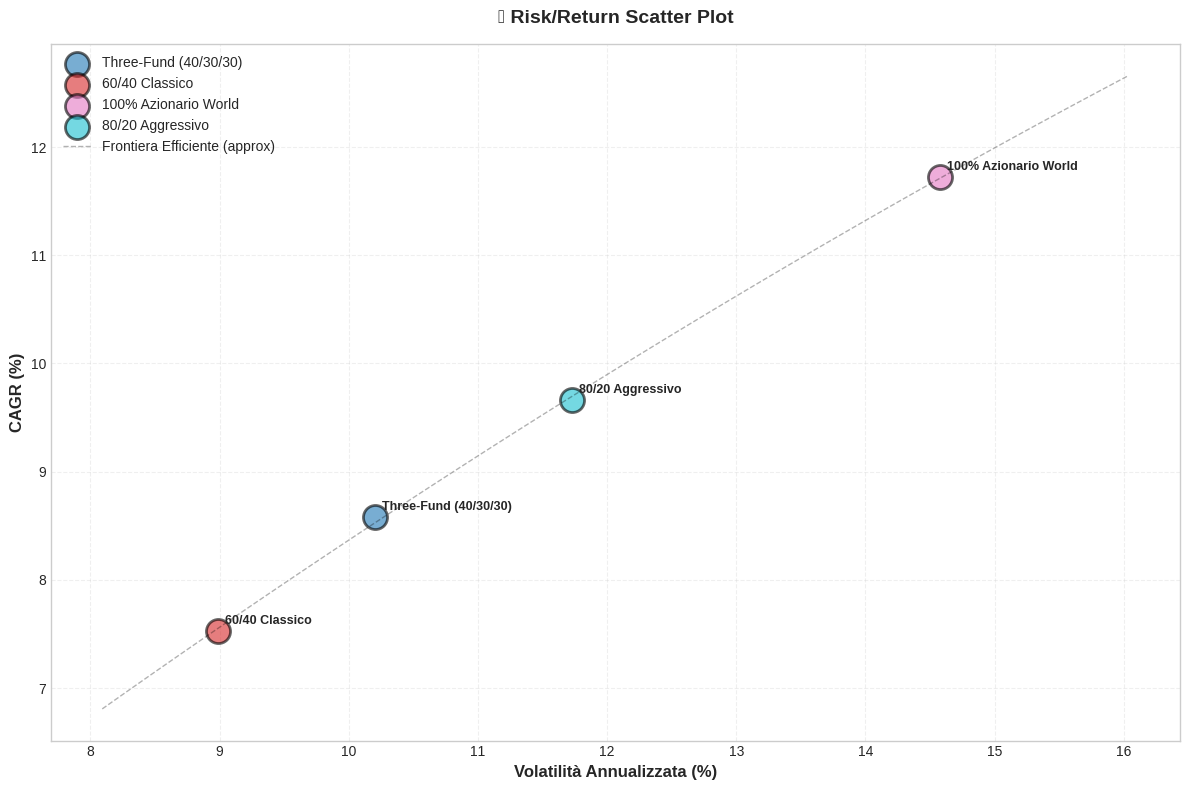


🔗 MATRICE CORRELAZIONI

Correlazioni asset base:
        BOND  EXUSA    USA  WORLD
BOND   1.000  0.062  0.033  0.041
EXUSA  0.062  1.000  0.754  0.852
USA    0.033  0.754  1.000  0.975
WORLD  0.041  0.852  0.975  1.000

✓ Grafico salvato: correlation_matrix.png


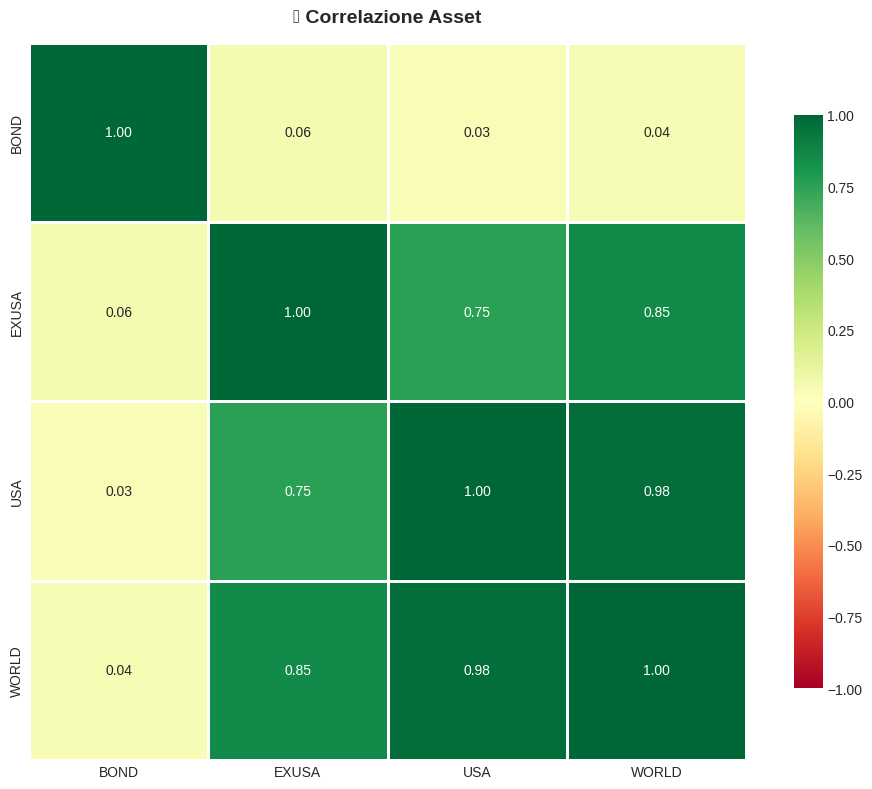


----------------------------------------------------------------------
Correlazioni portafogli:
----------------------------------------------------------------------
                       Three-Fund (40/30/30)  60/40 Classico  100% Azionario World  80/20 Aggressivo
Three-Fund (40/30/30)                  1.000           0.983                 0.975             0.983
60/40 Classico                         0.983           1.000                 0.981             0.993
100% Azionario World                   0.975           0.981                 1.000             0.997
80/20 Aggressivo                       0.983           0.993                 0.997             1.000

🔥 STRESS TEST - PEGGIORI PERIODI


Three-Fund (40/30/30):
--------------------------------------------------
  1. 2020-03-23: -20.07% (valore: €14,686)
  2. 2020-03-18: -19.79% (valore: €14,737)
  3. 2020-03-16: -19.06% (valore: €14,871)

60/40 Classico:
--------------------------------------------------
  1. 2020-03-23: -17

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ backtest_three_fund_complete.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ risk_return_scatter.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ correlation_matrix.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ metriche_portafogli.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ valori_portafogli_storici.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ rolling_returns.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ summary_backtest.txt

✓ Download completato!


In [5]:
!pip install -q yfinance pandas numpy matplotlib seaborn scipy

print("✓ Pacchetti installati con successo!")

# ============================================================================
# CELLA 2: IMPORT E CONFIGURAZIONE
# ============================================================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurazione grafici per Colab
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("✓ Librerie importate")
print(f"✓ Data esecuzione: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================================
# CELLA 3: CONFIGURAZIONE PARAMETRI
# ============================================================================

# ===== PARAMETRI MODIFICABILI =====

START_DATE = '2005-01-01'  # Data inizio backtest
END_DATE = datetime.now().strftime('%Y-%m-%d')
REBALANCE_FREQ = 'Y'  # Frequenza ribilanciamento: 'Y'=annuale, 'Q'=trimestrale
INITIAL_CAPITAL = 10000  # Capitale iniziale in EUR
TER_COST = 0.0015  # Costi medi annui (0.15%)
ROLLING_WINDOW = 10  # Finestra rolling returns (anni)

# ===== ETF UCITS REALI =====
# Nota: alcuni ETF sono recenti, usiamo proxy storici dove necessario

ETFS_PRIMARY = {
    'USA': 'VUSA.L',           # Vanguard S&P 500 UCITS ETF
    'EXUSA': 'VEUR.L',         # Vanguard FTSE Dev Europe UCITS (proxy ex-USA)
    'WORLD': 'SWDA.L',         # iShares MSCI World UCITS ETF
    'BOND': 'IEAG.L',          # iShares Euro Aggregate Bond UCITS
}

# Proxy fallback per dati storici lunghi
ETFS_FALLBACK = {
    'USA': 'SPY',              # SPDR S&P 500 (più storia)
    'EXUSA': 'EFA',            # iShares MSCI EAFE (ex-USA)
    'WORLD': 'URTH',           # iShares MSCI World ETF
    'BOND': 'IAGG',            # iShares Core Intl Aggregate Bond
}

# Indici di mercato (ultima risorsa)
INDICES = {
    'USA': '^GSPC',            # S&P 500 Index
    'EXUSA': '^N225',          # Nikkei 225 (non ideale ma disponibile)
    'WORLD': '^GSPC',          # S&P 500 come proxy
    'BOND': 'AGG',             # US Aggregate
}

# ===== COMPOSIZIONE PORTAFOGLI =====

PORTFOLIOS = {
    'Three-Fund (40/30/30)': {
        'USA': 0.40,
        'EXUSA': 0.30,
        'BOND': 0.30
    },
    '60/40 Classico': {
        'WORLD': 0.60,
        'BOND': 0.40
    },
    '100% Azionario World': {
        'WORLD': 1.00
    },
    '80/20 Aggressivo': {
        'WORLD': 0.80,
        'BOND': 0.20
    }
}

print("✓ Configurazione caricata")
print(f"\nPeriodo analisi: {START_DATE} → {END_DATE}")
print(f"Capitale iniziale: €{INITIAL_CAPITAL:,.0f}")
print(f"TER medio: {TER_COST*100:.2f}%")
print(f"Rolling window: {ROLLING_WINDOW} anni")
print(f"\nNumero portafogli: {len(PORTFOLIOS)}")

# ============================================================================
# CELLA 4: FUNZIONI DOWNLOAD DATI
# ============================================================================

def download_with_fallback(asset_name, start_date, end_date):
    """
    Scarica dati con sistema di fallback a 3 livelli:
    1. ETF UCITS primario
    2. ETF US/Global con più storia
    3. Indice di mercato
    """

    attempts = [
        ('UCITS', ETFS_PRIMARY.get(asset_name)),
        ('Fallback ETF', ETFS_FALLBACK.get(asset_name)),
        ('Index', INDICES.get(asset_name))
    ]

    for level, ticker in attempts:
        if ticker is None:
            continue

        try:
            print(f"  Tentativo {level}: {ticker}...", end=' ')

            df = yf.download(
                ticker,
                start=start_date,
                end=end_date,
                progress=False,
                auto_adjust=True
            )

            if not df.empty and len(df) > 252:  # Almeno 1 anno
                print(f"✓ ({len(df)} giorni)")
                return df['Close'], ticker, level
            else:
                print(f"✗ (dati insufficienti)")

        except Exception as e:
            print(f"✗ ({str(e)[:30]})")

    print(f"  ❌ Impossibile scaricare {asset_name}")
    return None, None, None

def download_all_data(start_date, end_date):
    """Scarica tutti gli asset necessari"""

    print("\n" + "="*70)
    print("📊 DOWNLOAD DATI STORICI")
    print("="*70 + "\n")

    data = pd.DataFrame()
    metadata = {}

    # Trova tutti gli asset unici richiesti
    unique_assets = set()
    for portfolio in PORTFOLIOS.values():
        unique_assets.update(portfolio.keys())

    print(f"Asset da scaricare: {', '.join(unique_assets)}\n")

    for asset in sorted(unique_assets):
        print(f"📈 {asset}:")
        prices, ticker, source = download_with_fallback(asset, start_date, end_date)

        if prices is not None:
            data[asset] = prices
            metadata[asset] = {'ticker': ticker, 'source': source}
        else:
            print(f"  ⚠️  ATTENZIONE: {asset} non disponibile")

    if data.empty:
        raise ValueError("❌ Nessun dato scaricato. Impossibile continuare.")

    # Allinea date
    data = data.dropna()

    print(f"\n✓ Download completato!")
    print(f"✓ Periodo effettivo: {data.index[0].date()} → {data.index[-1].date()}")
    print(f"✓ Giorni di trading: {len(data):,}")
    print(f"✓ Asset disponibili: {len(data.columns)}")

    return data, metadata

# ============================================================================
# CELLA 5: FUNZIONI CALCOLO METRICHE
# ============================================================================

def calculate_returns(prices):
    """Calcola rendimenti giornalieri"""
    return prices.pct_change().dropna()

def calculate_portfolio_returns(returns, weights, ter_cost):
    """
    Calcola rendimenti portafoglio con ribilanciamento e costi
    """
    # Verifica asset disponibili
    available_weights = {k: v for k, v in weights.items() if k in returns.columns}

    if not available_weights:
        return None

    # Rinormalizza pesi
    total = sum(available_weights.values())
    normalized_weights = {k: v/total for k, v in available_weights.items()}

    # Calcola rendimenti ponderati
    portfolio_returns = pd.Series(0, index=returns.index)

    for asset, weight in normalized_weights.items():
        portfolio_returns += returns[asset] * weight

    # Sottrai costi (giornalieri)
    portfolio_returns -= ter_cost / 252

    return portfolio_returns

def calculate_metrics(returns_series, name="Portfolio"):
    """
    Calcola tutte le metriche di performance
    """
    if returns_series is None or len(returns_series) == 0:
        return None

    # Rimuovi NaN
    returns_series = returns_series.dropna()

    # Rendimento totale
    total_return = (1 + returns_series).prod() - 1

    # CAGR
    years = len(returns_series) / 252
    if years > 0:
        cagr = (1 + total_return) ** (1/years) - 1
    else:
        cagr = 0

    # Volatilità annualizzata
    volatility = returns_series.std() * np.sqrt(252)

    # Sharpe Ratio (risk-free = 2%)
    risk_free_rate = 0.02
    sharpe = (cagr - risk_free_rate) / volatility if volatility > 0 else 0

    # Sortino Ratio
    downside_returns = returns_series[returns_series < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino = (cagr - risk_free_rate) / downside_std if downside_std > 0 else 0

    # Max Drawdown
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()

    # Calmar Ratio
    calmar = abs(cagr / max_drawdown) if max_drawdown != 0 else 0

    # Best/Worst year
    annual_returns = (1 + returns_series).resample('Y').prod() - 1
    best_year = annual_returns.max() if len(annual_returns) > 0 else 0
    worst_year = annual_returns.min() if len(annual_returns) > 0 else 0

    # Percentuale anni positivi
    positive_years = (annual_returns > 0).sum() / len(annual_returns) if len(annual_returns) > 0 else 0

    return {
        'CAGR': cagr,
        'Volatilità': volatility,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Calmar Ratio': calmar,
        'Max Drawdown': max_drawdown,
        'Best Year': best_year,
        'Worst Year': worst_year,
        '% Anni Positivi': positive_years,
        'Rendimento Totale': total_return
    }

def calculate_rolling_returns(prices, window_years=10):
    """
    Calcola rolling returns su finestra mobile
    """
    returns = prices.pct_change().dropna()
    window_days = window_years * 252

    if len(returns) < window_days:
        print(f"  ⚠️  Dati insufficienti per rolling {window_years}Y")
        return pd.Series()

    rolling_cagr = []
    dates = []

    for i in range(window_days, len(returns)):
        window_rets = returns.iloc[i-window_days:i]
        total_ret = (1 + window_rets).prod() - 1
        cagr = (1 + total_ret) ** (1/window_years) - 1

        rolling_cagr.append(cagr)
        dates.append(returns.index[i])

    return pd.Series(rolling_cagr, index=dates)

print("✓ Funzioni di calcolo caricate")

# ============================================================================
# CELLA 6: ESECUZIONE BACKTEST
# ============================================================================

def run_backtest():
    """
    Esegue backtest completo di tutti i portafogli
    """

    print("\n" + "="*70)
    print("🚀 ESECUZIONE BACKTEST")
    print("="*70)

    # 1. Download dati
    data, metadata = download_all_data(START_DATE, END_DATE)

    # 2. Calcola rendimenti base
    returns = calculate_returns(data)

    print("\n" + "-"*70)
    print("📊 COSTRUZIONE PORTAFOGLI")
    print("-"*70 + "\n")

    # 3. Costruisci portafogli
    portfolio_returns = {}
    portfolio_values = {}

    for pf_name, weights in PORTFOLIOS.items():
        print(f"Costruendo: {pf_name}")
        print(f"  Allocazione: {weights}")

        pf_returns = calculate_portfolio_returns(returns, weights, TER_COST)

        if pf_returns is not None:
            portfolio_returns[pf_name] = pf_returns
            portfolio_values[pf_name] = (1 + pf_returns).cumprod() * INITIAL_CAPITAL
            print(f"  ✓ Completato")
        else:
            print(f"  ✗ Asset mancanti, skip")

        print()

    # 4. Calcola metriche
    print("-"*70)
    print("📈 CALCOLO METRICHE")
    print("-"*70 + "\n")

    metrics_all = {}

    for pf_name, pf_returns in portfolio_returns.items():
        print(f"Metriche {pf_name}...", end=' ')
        metrics = calculate_metrics(pf_returns, pf_name)
        if metrics:
            metrics_all[pf_name] = metrics
            print("✓")
        else:
            print("✗")

    metrics_df = pd.DataFrame(metrics_all).T

    # 5. Rolling returns
    print("\n" + "-"*70)
    print(f"📉 CALCOLO ROLLING RETURNS ({ROLLING_WINDOW} ANNI)")
    print("-"*70 + "\n")

    rolling_returns = {}

    for pf_name, values in portfolio_values.items():
        print(f"Rolling {pf_name}...", end=' ')
        roll = calculate_rolling_returns(values, ROLLING_WINDOW)
        if not roll.empty:
            rolling_returns[pf_name] = roll
            print(f"✓ ({len(roll)} periodi)")
        else:
            print("✗ (dati insufficienti)")

    return {
        'data': data,
        'metadata': metadata,
        'returns': returns,
        'portfolio_returns': portfolio_returns,
        'portfolio_values': portfolio_values,
        'metrics': metrics_df,
        'rolling_returns': rolling_returns
    }

# ESEGUI BACKTEST
results = run_backtest()

print("\n" + "="*70)
print("✓ BACKTEST COMPLETATO!")
print("="*70)

# ============================================================================
# CELLA 7: VISUALIZZA METRICHE
# ============================================================================

print("\n" + "="*70)
print("📊 METRICHE DI PERFORMANCE")
print("="*70 + "\n")

metrics_display = results['metrics'].copy()

# Formatta per visualizzazione
for col in metrics_display.columns:
    if col in ['CAGR', 'Volatilità', 'Max Drawdown', 'Best Year', 'Worst Year',
               'Rendimento Totale', '% Anni Positivi']:
        metrics_display[col] = metrics_display[col] * 100

# Arrotonda
metrics_display = metrics_display.round(2)

# Rinomina colonne per chiarezza
rename_map = {
    'CAGR': 'CAGR (%)',
    'Volatilità': 'Vol. (%)',
    'Max Drawdown': 'Max DD (%)',
    'Best Year': 'Best Year (%)',
    'Worst Year': 'Worst Year (%)',
    'Rendimento Totale': 'Rend. Tot. (%)',
    '% Anni Positivi': '% Anni + (%)'
}

metrics_display = metrics_display.rename(columns=rename_map)

# Mostra tabella
print(metrics_display.to_string())

print("\n" + "-"*70)
print("💰 VALORE FINALE PORTAFOGLI")
print("-"*70 + "\n")

final_values = pd.DataFrame({
    'Valore Iniziale': INITIAL_CAPITAL,
    'Valore Finale': {name: values.iloc[-1]
                      for name, values in results['portfolio_values'].items()},
})

final_values['Guadagno (€)'] = final_values['Valore Finale'] - final_values['Valore Iniziale']
final_values['Guadagno (%)'] = (final_values['Valore Finale'] / final_values['Valore Iniziale'] - 1) * 100

print(final_values.to_string(float_format=lambda x: f"€{x:,.0f}" if x > 100 else f"{x:.1f}%"))

# ============================================================================
# CELLA 8: GRAFICI PRINCIPALI
# ============================================================================

print("\n📊 Generazione grafici...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)

colors = plt.cm.tab10(np.linspace(0, 1, len(results['portfolio_values'])))

# ===== GRAFICO 1: Valore Portafogli nel Tempo =====
ax1 = fig.add_subplot(gs[0, :])

for (name, values), color in zip(results['portfolio_values'].items(), colors):
    ax1.plot(values.index, values, label=name, linewidth=2.5, color=color, alpha=0.9)

ax1.set_title('📈 Evoluzione Valore Portafogli', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Valore (€)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.axhline(y=INITIAL_CAPITAL, color='gray', linestyle=':', alpha=0.6, linewidth=1.5)
ax1.text(results['data'].index[10], INITIAL_CAPITAL*1.02,
         f'Capitale Iniziale: €{INITIAL_CAPITAL:,.0f}',
         fontsize=9, color='gray')

# Formatta asse Y
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

# ===== GRAFICO 2: Drawdown =====
ax2 = fig.add_subplot(gs[1, 0])

for (name, values), color in zip(results['portfolio_values'].items(), colors):
    cumulative = values / values.expanding().max() - 1
    ax2.fill_between(cumulative.index, cumulative * 100, 0,
                     alpha=0.3, color=color)
    ax2.plot(cumulative.index, cumulative * 100,
            label=name, linewidth=2, color=color, alpha=0.9)

ax2.set_title('📉 Drawdown Storico', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Drawdown (%)', fontsize=11)
ax2.legend(loc='lower left', fontsize=9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

# ===== GRAFICO 3: Rendimenti Annuali =====
ax3 = fig.add_subplot(gs[1, 1])

annual_data = []
labels = []

for name, rets in results['portfolio_returns'].items():
    annual_rets = (1 + rets).resample('Y').prod() - 1
    annual_data.append(annual_rets * 100)
    labels.append(name.replace(' ', '\n'))

bp = ax3.boxplot(annual_data, labels=labels, patch_artist=True,
                 medianprops=dict(color='red', linewidth=2),
                 boxprops=dict(facecolor='lightblue', alpha=0.7))

ax3.set_title('📊 Distribuzione Rendimenti Annuali', fontsize=14, fontweight='bold', pad=15)
ax3.set_ylabel('Rendimento Annuale (%)', fontsize=11)
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=8)

# ===== GRAFICO 4: Rolling Returns =====
ax4 = fig.add_subplot(gs[2, :])

for (name, roll), color in zip(results['rolling_returns'].items(), colors):
    ax4.plot(roll.index, roll * 100, label=name, linewidth=2.5,
            color=color, alpha=0.9)

ax4.set_title(f'📈 Rolling Returns {ROLLING_WINDOW} Anni',
             fontsize=14, fontweight='bold', pad=15)
ax4.set_ylabel('CAGR Annualizzato (%)', fontsize=11)
ax4.legend(loc='lower left', fontsize=10, framealpha=0.95)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

# Aggiungi bande
if len(results['rolling_returns']) > 0:
    first_roll = list(results['rolling_returns'].values())[0]
    ax4.axhline(y=first_roll.mean()*100, color='green',
               linestyle=':', alpha=0.5, linewidth=1.5)
    ax4.text(first_roll.index[10], first_roll.mean()*100*1.02,
            f'Media: {first_roll.mean()*100:.1f}%',
            fontsize=9, color='green')

plt.suptitle(f'Backtest Three-Fund Portfolio | {START_DATE} → {END_DATE}',
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('backtest_three_fund_complete.png', dpi=300, bbox_inches='tight')
print("✓ Grafico salvato: backtest_three_fund_complete.png")
plt.show()

# ============================================================================
# CELLA 9: ANALISI ROLLING DETTAGLIATA
# ============================================================================

print("\n" + "="*70)
print(f"📊 ANALISI ROLLING RETURNS {ROLLING_WINDOW} ANNI")
print("="*70 + "\n")

rolling_stats = {}

for name, roll in results['rolling_returns'].items():
    if roll.empty:
        continue

    rolling_stats[name] = {
        'Min CAGR (%)': roll.min() * 100,
        'Max CAGR (%)': roll.max() * 100,
        'Media CAGR (%)': roll.mean() * 100,
        'Mediana CAGR (%)': roll.median() * 100,
        'Dev. Std. (%)': roll.std() * 100,
        '% Periodi >0%': (roll > 0).sum() / len(roll) * 100,
        '% Periodi >5%': (roll > 0.05).sum() / len(roll) * 100,
    }

rolling_df = pd.DataFrame(rolling_stats).T

if not rolling_df.empty:
    print(rolling_df.round(2).to_string())

    print("\n💡 Insights:")
    best_min = rolling_df['Min CAGR (%)'].idxmax()
    best_consistency = rolling_df['% Periodi >0%'].idxmax()

    print(f"  • Miglior worst-case: {best_min}")
    print(f"  • Più consistente: {best_consistency}")

# ============================================================================
# CELLA 10: CONFRONTO RISK-ADJUSTED RETURNS
# ============================================================================

print("\n" + "="*70)
print("⚖️  RISK-ADJUSTED RETURNS")
print("="*70 + "\n")

risk_adj = results['metrics'][['CAGR', 'Volatilità', 'Sharpe Ratio',
                                'Sortino Ratio', 'Calmar Ratio']].copy()

risk_adj['CAGR'] *= 100
risk_adj['Volatilità'] *= 100

risk_adj = risk_adj.round(2)

print(risk_adj.to_string())

# Grafico Scatter Risk/Return
fig, ax = plt.subplots(figsize=(12, 8))

for idx, (name, row) in enumerate(risk_adj.iterrows()):
    ax.scatter(row['Volatilità'], row['CAGR'],
              s=300, alpha=0.6, color=colors[idx],
              edgecolors='black', linewidth=2, label=name)

    # Annotazione
    ax.annotate(name, (row['Volatilità'], row['CAGR']),
               xytext=(5, 5), textcoords='offset points',
               fontsize=9, fontweight='bold')

# Linea frontiera efficiente teorica
if len(risk_adj) > 1:
    x_line = np.linspace(risk_adj['Volatilità'].min()*0.9,
                         risk_adj['Volatilità'].max()*1.1, 100)
    # Fit parabolico semplice
    coeffs = np.polyfit(risk_adj['Volatilità'], risk_adj['CAGR'], 2)
    y_line = np.polyval(coeffs, x_line)
    ax.plot(x_line, y_line, 'k--', alpha=0.3, linewidth=1,
           label='Frontiera Efficiente (approx)')

ax.set_xlabel('Volatilità Annualizzata (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('CAGR (%)', fontsize=12, fontweight='bold')
ax.set_title('🎯 Risk/Return Scatter Plot', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('risk_return_scatter.png', dpi=300, bbox_inches='tight')
print("\n✓ Grafico salvato: risk_return_scatter.png")
plt.show()

# ============================================================================
# CELLA 11: ANALISI CORRELAZIONI
# ============================================================================

print("\n" + "="*70)
print("🔗 MATRICE CORRELAZIONI")
print("="*70 + "\n")

# Calcola correlazioni tra asset base
correlation_matrix = results['returns'].corr()

print("Correlazioni asset base:")
print(correlation_matrix.round(3).to_string())

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f',
           cmap='RdYlGn', center=0, vmin=-1, vmax=1,
           square=True, linewidths=1, cbar_kws={"shrink": 0.8})

ax.set_title('🔗 Correlazione Asset', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Grafico salvato: correlation_matrix.png")
plt.show()

# Correlazione portafogli
print("\n" + "-"*70)
print("Correlazioni portafogli:")
print("-"*70)

portfolio_corr = pd.DataFrame(results['portfolio_returns']).corr()
print(portfolio_corr.round(3).to_string())

# ============================================================================
# CELLA 12: SCENARIO STRESS TEST
# ============================================================================

print("\n" + "="*70)
print("🔥 STRESS TEST - PEGGIORI PERIODI")
print("="*70 + "\n")

# Trova i 3 peggiori drawdown per ogni portafoglio
for name, values in results['portfolio_values'].items():
    cumulative = values / values.expanding().max() - 1

    # Trova minimi locali (drawdown peaks)
    drawdowns = []
    for i in range(1, len(cumulative)-1):
        if cumulative.iloc[i] < cumulative.iloc[i-1] and cumulative.iloc[i] < cumulative.iloc[i+1]:
            drawdowns.append({
                'date': cumulative.index[i],
                'drawdown': cumulative.iloc[i],
                'value': values.iloc[i]
            })

    # Ordina per drawdown
    drawdowns.sort(key=lambda x: x['drawdown'])

    print(f"\n{name}:")
    print("-" * 50)

    for i, dd in enumerate(drawdowns[:3], 1):
        print(f"  {i}. {dd['date'].strftime('%Y-%m-%d')}: "
              f"{dd['drawdown']*100:.2f}% "
              f"(valore: €{dd['value']:,.0f})")

# ============================================================================
# CELLA 13: ESPORTA RISULTATI
# ============================================================================

print("\n" + "="*70)
print("💾 ESPORTAZIONE RISULTATI")
print("="*70 + "\n")

# 1. Esporta metriche
results['metrics'].to_csv('metriche_portafogli.csv')
print("✓ metriche_portafogli.csv")

# 2. Esporta valori storici
values_df = pd.DataFrame(results['portfolio_values'])
values_df.to_csv('valori_portafogli_storici.csv')
print("✓ valori_portafogli_storici.csv")

# 3. Esporta rolling returns
if results['rolling_returns']:
    rolling_df = pd.DataFrame(results['rolling_returns'])
    rolling_df.to_csv('rolling_returns.csv')
    print("✓ rolling_returns.csv")

# 4. Esporta summary
with open('summary_backtest.txt', 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("BACKTEST THREE-FUND PORTFOLIO - SUMMARY\n")
    f.write("="*70 + "\n\n")

    f.write(f"Data esecuzione: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Periodo analisi: {START_DATE} → {END_DATE}\n")
    f.write(f"Capitale iniziale: €{INITIAL_CAPITAL:,.0f}\n")
    f.write(f"TER medio: {TER_COST*100:.2f}%\n\n")

    f.write("-"*70 + "\n")
    f.write("METRICHE PERFORMANCE\n")
    f.write("-"*70 + "\n\n")
    f.write(metrics_display.to_string())
    f.write("\n\n")

    f.write("-"*70 + "\n")
    f.write("VALORI FINALI\n")
    f.write("-"*70 + "\n\n")
    f.write(final_values.to_string())
    f.write("\n\n")

    f.write("-"*70 + "\n")
    f.write("ASSET UTILIZZATI\n")
    f.write("-"*70 + "\n\n")
    for asset, meta in results['metadata'].items():
        f.write(f"{asset}: {meta['ticker']} ({meta['source']})\n")

print("✓ summary_backtest.txt")

print("\n✓ Tutti i file esportati con successo!")

# ============================================================================
# CELLA 14: CONCLUSIONI E RACCOMANDAZIONI
# ============================================================================

print("\n" + "="*70)
print("💡 CONCLUSIONI E RACCOMANDAZIONI")
print("="*70 + "\n")

# Trova i migliori portafogli per categoria
best_cagr = results['metrics']['CAGR'].idxmax()
best_sharpe = results['metrics']['Sharpe Ratio'].idxmax()
best_sortino = results['metrics']['Sortino Ratio'].idxmax()
best_calmar = results['metrics']['Calmar Ratio'].idxmax()
lowest_dd = results['metrics']['Max Drawdown'].idxmax()  # Meno negativo

print("🏆 MIGLIORI PORTAFOGLI PER METRICA:\n")
print(f"  • Massimo rendimento (CAGR): {best_cagr}")
print(f"    └─ CAGR: {results['metrics'].loc[best_cagr, 'CAGR']*100:.2f}%")

print(f"\n  • Miglior Sharpe Ratio: {best_sharpe}")
print(f"    └─ Sharpe: {results['metrics'].loc[best_sharpe, 'Sharpe Ratio']:.2f}")

print(f"\n  • Miglior Sortino Ratio: {best_sortino}")
print(f"    └─ Sortino: {results['metrics'].loc[best_sortino, 'Sortino Ratio']:.2f}")

print(f"\n  • Miglior Calmar Ratio: {best_calmar}")
print(f"    └─ Calmar: {results['metrics'].loc[best_calmar, 'Calmar Ratio']:.2f}")

print(f"\n  • Minimo Drawdown: {lowest_dd}")
print(f"    └─ Max DD: {results['metrics'].loc[lowest_dd, 'Max Drawdown']*100:.2f}%")

# Raccomandazioni
print("\n" + "-"*70)
print("📌 RACCOMANDAZIONI:\n")

cagr_vals = results['metrics']['CAGR'] * 100
sharpe_vals = results['metrics']['Sharpe Ratio']
dd_vals = results['metrics']['Max Drawdown'] * 100

# Normalizza score (0-100)
score = pd.DataFrame({
    'CAGR': (cagr_vals - cagr_vals.min()) / (cagr_vals.max() - cagr_vals.min()) * 100,
    'Sharpe': (sharpe_vals - sharpe_vals.min()) / (sharpe_vals.max() - sharpe_vals.min()) * 100,
    'DD': (dd_vals - dd_vals.min()) / (dd_vals.max() - dd_vals.min()) * 100,
})

score['Score Totale'] = score.mean(axis=1)
score = score.sort_values('Score Totale', ascending=False)

print("Score Bilanciato (CAGR + Sharpe + DD protection):\n")
for i, (name, row) in enumerate(score.iterrows(), 1):
    print(f"  {i}. {name}: {row['Score Totale']:.1f}/100")
    print(f"     └─ CAGR: {row['CAGR']:.0f} | Sharpe: {row['Sharpe']:.0f} | "
          f"DD Protection: {row['DD']:.0f}")

print("\n" + "-"*70)
print("💬 CONSIDERAZIONI FINALI:\n")

print("""
  1. Il portafoglio migliore dipende dal TUO profilo:
     • Aggressivo → 80/20 o 100% Azionario
     • Bilanciato → Three-Fund o 60/40
     • Conservativo → 60/40 con più bond

  2. Il Three-Fund Portfolio offre:
     ✓ Buon equilibrio rischio/rendimento
     ✓ Diversificazione geografica
     ✓ Drawdown contenuti

  3. Il ribilanciamento annuale è sufficiente

  4. I costi (TER) hanno impatto significativo sul lungo periodo

  5. Nessun portafoglio è perfetto per tutti i mercati
     → L'importante è avere un piano e seguirlo
""")

print("="*70)
print("✓ ANALISI COMPLETA TERMINATA!")
print("="*70)

# ============================================================================
# CELLA 15: DOWNLOAD FILE (Colab)
# ============================================================================

# Scarica tutti i file generati
from google.colab import files

print("\n📥 Download file generati...\n")

file_list = [
    'backtest_three_fund_complete.png',
    'risk_return_scatter.png',
    'correlation_matrix.png',
    'metriche_portafogli.csv',
    'valori_portafogli_storici.csv',
    'rolling_returns.csv',
    'summary_backtest.txt'
]

for filename in file_list:
    try:
        files.download(filename)
        print(f"✓ {filename}")
    except:
        print(f"✗ {filename} (non trovato)")

print("\n✓ Download completato!")